<a href="https://colab.research.google.com/github/ginomempin/machine-learning-tutorials/blob/master/src/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OVERVIEW

This notebook demonstrates **Style Transfer** using Convolutional Neural Networks.

### Reference

[ginomempin / machine-learning-tutorials / docs / StyleTransfer.md](https://github.com/ginomempin/machine-learning-tutorials/blob/master/docs/StyleTransfer.md)

### Note

This notebook requires the use of GPU (or not if you want slow/long training times).  

When running in Google Colab:
1. Select "Runtime" from the menu
1. Select "GPU" as the hardware accelerator type.

In [1]:
!pip install matplotlib
!pip install torch torchvision
!pip install Pillow

In [0]:
%matplotlib inline

import cv2

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
from torchvision import models, transforms

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup the Model

In [4]:
model = models.vgg19(pretrained=True)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Setup the Feature Extractor

In [5]:
model_features = model.features

# Freeze parameters to avoid updating them during backpropagation1
for param in model_features.parameters():
    param.requires_grad = False

model_features.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# Setup the Images

In [0]:
def load_image(img_path, max_size=400, shape=None):
    print(f"Loading {img_path}")
    image = Image.open(img_path)

    # Ensure image colorspace matches what's needed by the model
    # From the print(model), it accepts 3-channel images
    image = image.convert("RGB")

    # Compute maximum size of images to process
    # This is mainly to reduce required computational resources
    max_image_size = max(image.size)
    if max_image_size > max_size:
        size = max_size
    else:
        size = max_image_size
    print(f"Got max(image.size)={max_image_size}")
    print(f"Set size to {size}")

    if shape is not None:
        size = shape
    print(f"Got shape={shape}")
    print(f"Set size to {size}")    

    # Apply necessary image transformations to make it compatible
    # as input to the model.
    in_transform = transforms.Compose([
        # This will adjust the size of smaller edge of the image.
        # Set it such that the smaller edge will have maximum size 
        # equal to max_size. The overall aspect ratio is maintained.
        transforms.Resize(size),

        transforms.ToTensor(),

        transforms.Normalize(
            (0.5, 0.5, 0.5),    # mean
            (0.5, 0.5, 0.5)     # standard deviation     
        )
    ])
    image = in_transform(image)
    
    # Add the necessary dimensions (i.e. 3D -> 4D)
    image = image.unsqueeze(0)

    return image

In [7]:
# Make sure to upload the test images to Google Colab before running this cell.

img_content = load_image("City.jpg").to(device)

# Make sure the style image matches the size and dimensions of the content image. 
# This will make style transfer more effective. For our case, we only need the
# WxH shape to match.
img_style = load_image("StarryNight.jpg", shape=img_content.shape[-2:]).to(device)

Loading City.jpg
Got max(image.size)=4096
Set size to 400
Got shape=None
Set size to 400
Loading StarryNight.jpg
Got max(image.size)=1650
Set size to 400
Got shape=torch.Size([400, 600])
Set size to torch.Size([400, 600])


In [0]:
# To plot, we need to convert the Tensor back to Numpy array.
def img_convert(tensor: torch.Tensor):
    image = tensor.cpu().clone().detach().numpy()

    # Convert from 1x3xWxH shape to WxHx3
    # print(f"Original image dims: {image.shape}")
    image = image.squeeze(0).transpose(1, 2, 0)
    # print(f"Transposed image dims: {image.shape}")

    # De-normalize (reverse the normalization process earlier)
    # Convert it from [-1, 1] back to the original [0, 1]
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    # print(f"Converted image dims: {image.shape}")
    return image

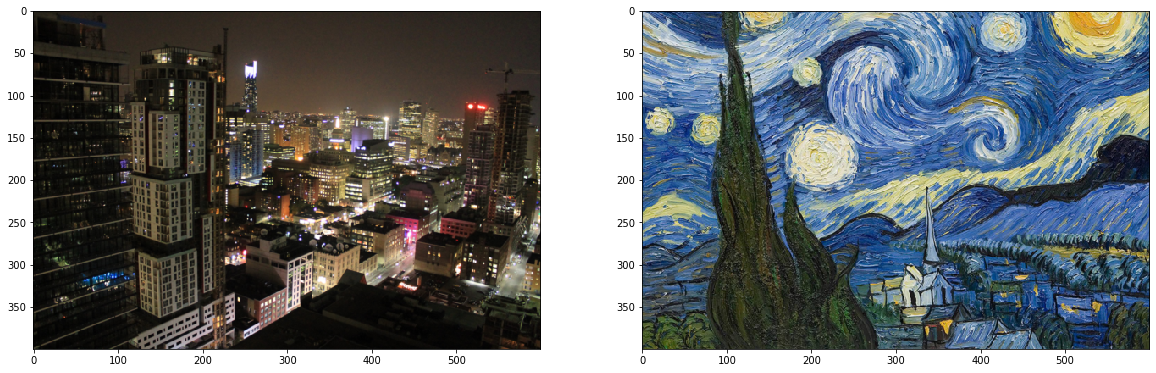

In [9]:
fig = plt.figure(figsize=(20, 10))

axis1 = fig.add_subplot(1, 2, 1)
axis1.imshow(img_convert(img_content))

axis2 = fig.add_subplot(1, 2, 2)
axis2.imshow(img_convert(img_style))

# Setup Feature Extraction

In [0]:
def get_features(image, model):
    # Choose specific layers from which to extract features
    # Based on the whitepaper 
    #   Style Transfer using Convolutional Neural Networks
    #   https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf
    # The relevant layers are the 1st convolutional layers
    # from each convolution-relu-maxpool batch, plus the
    # specific 'conv4_2' layer (4th batch, 2nd convolution).
    layers = {
        '0'  : 'conv1_1',   # style
        '5'  : 'conv2_1',   # style
        '10' : 'conv3_1',   # style
        '19' : 'conv4_1',   # style
        '21' : 'conv4_2',   # content
        '28' : 'conv5_1',   # style
    }
    features = {}

    for layer_idx, layer in model._modules.items():
        image = layer(image)
        if layer_idx in layers:
            features[layers[layer_idx]] = image
        
    return features

In [11]:
content_features = get_features(img_content, model_features)
print(type(content_features), len(content_features))
print(content_features.keys())

<class 'dict'> 6
dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1'])


In [12]:
style_features = get_features(img_style, model_features)
print(type(style_features), len(style_features))
print(style_features.keys())

<class 'dict'> 6
dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1'])


# Setup Gram Matrix

In [0]:
def gram_matrix(tensor: torch.Tensor):
    batch_size, image_depth, image_height, image_width = tensor.size()
    # print(f"batch_size:{batch_size}")
    # print(f"image_depth:{image_depth}")
    # print(f"image_height:{image_height}")
    # print(f"image_width:{image_width}")

    # Convert to 2D matrix
    matrix = tensor.view(image_depth, image_height * image_width)

    return torch.mm(matrix, matrix.t())

In [14]:
style_grams = { layer: gram_matrix(style_features[layer]) for layer in style_features }
print(type(style_grams), len(style_grams))
print(style_grams.keys())

<class 'dict'> 6
dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1'])


# Setup Style Weights

In [0]:
# Customize which style to prioritize when transferring to the content
style_weights = {
    "conv1_1" : 1.0,
    "conv2_1" : 0.75,
    "conv3_1" : 0.2,
    "conv4_1" : 0.2,
    "conv5_1" : 0.2
}

# Setup Content/Style Ratio

In [0]:
# Customize the ratio between the content image and the style image
# This is referred to as the alpha-beta, where the alpha represents
# the content image weight, and the beta represents the style image
# weight. It basically means how much of the content and the style
# to "keep" when merging both into the target image. The lower the
# ratio, the more style is applied instead of the content.
content_weight = 1  # alpha
style_weight = 1e6  # beta

# Setup Target Image

In [0]:
# In the original whitepaper, it started with a white noise image.
# Then merged the content features and style features into the 
# target image. For our purposes, to make it simpler, we start off
# with a clone of the content image, and then apply the style features
# to it.
img_target = img_content.clone()

# We want the target image to be iteratively updated with the styles.
# For this, we need to enable gradients.
img_target = img_target.requires_grad_(True)

img_target = img_target.to(device)

# Execution

In [0]:
# Define the interval when to show updated target image
show_every = 300

# Define the optimization parameters
optimizer = optim.Adam(
    [img_target], 
    lr=0.003        # Based on empirical observation
)

# Define how many steps for style transfer
#
# This is going to be a balance between desired results
# and time constraints. More steps means better results
# but also more time to complete.
#
# From empirical observation, 2100 is the minimum OK number
# of steps.
steps = 2100

# Setup storage of incremental updates to the image
#
# Since we are running this on a Google Colab notebook,
# collecting all the images would take up too much memory.
# So we set a limit for the batch size (300 images).
height, width, channels = img_convert(img_target).shape
image_array = np.empty(shape=(300+1, height, width, channels))
capture_frame = steps / 300
frame_counter = 0

Iteration: 300
Total Loss: 2887783.5


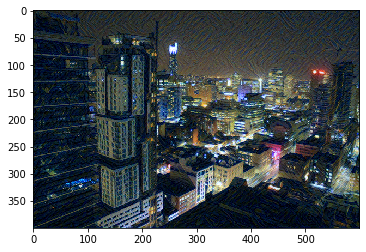

Iteration: 600
Total Loss: 949846.6875


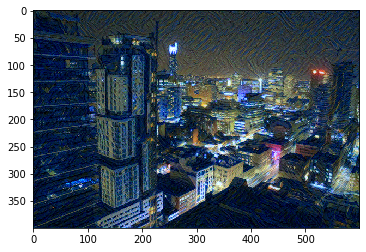

Iteration: 900
Total Loss: 658561.4375


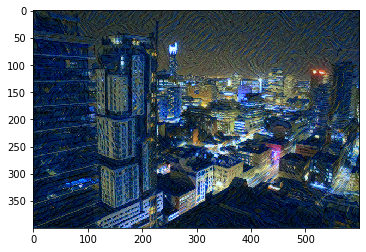

Iteration: 1200
Total Loss: 510601.6875


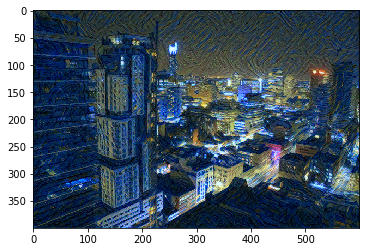

Iteration: 1500
Total Loss: 400877.15625


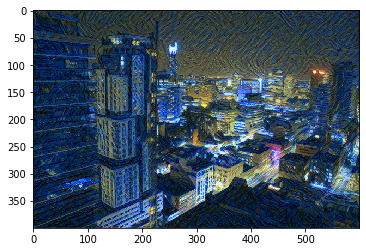

Iteration: 1800
Total Loss: 315012.46875


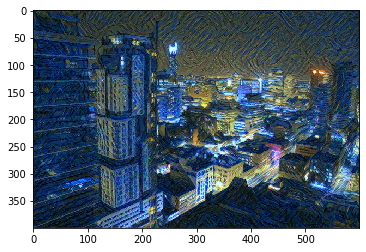

Iteration: 2100
Total Loss: 246957.234375


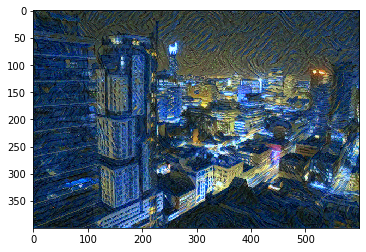

In [19]:
for ii in range(1, steps+1):
    # Collect features
    target_features = get_features(img_target, model_features)

    # Calcuate content loss using Mean-Squared Loss
    #
    # We want the loss to be zero, meaning the target image's content features 
    # matches the original image's content features.
    content_loss = torch.mean( (target_features["conv4_2"] - content_features["conv4_2"])**2 )
    
    # Calculate style loss using Mean-Squared Loss
    #
    # Same with content loss, we want this loss to be zero, meaning the target
    # image's style features matches the style image's style features.
    # This is obtained from the combined losses of the style-related layers of 
    # the model.
    #
    # In addition, we consider the weights for each style.
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape

        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        
        layer_style_loss = style_weights[layer] * torch.mean( (target_gram - style_gram)**2 )
        layer_style_loss /= (d * h * w)  # Normalize because of gram_matrix computation

        style_loss += layer_style_loss

    total_loss = (content_weight * content_loss) + (style_weight * style_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if ii % show_every == 0:
        print(f"Iteration: {ii}")
        print(f"Total Loss: {total_loss.item()}")
        plt.imshow(img_convert(img_target))
        plt.show()

    if ii % capture_frame == 0:
        image_array[frame_counter] = img_convert(img_target)
        frame_counter += 1

# Visualization

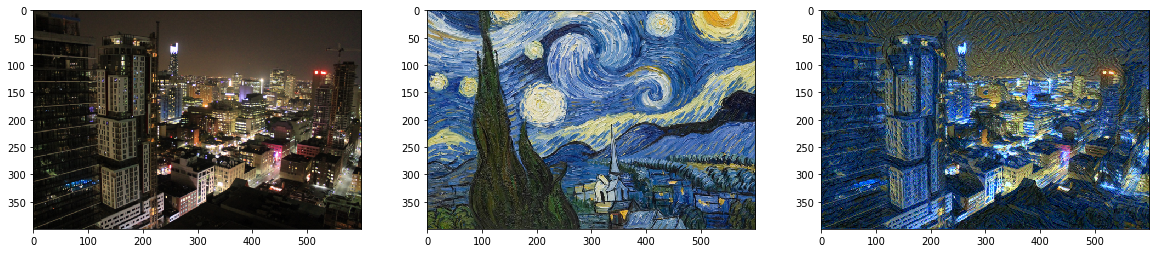

In [23]:
fig = plt.figure(figsize=(20, 10))

axis1 = fig.add_subplot(1, 3, 1)
axis1.imshow(img_convert(img_content))

axis2 = fig.add_subplot(1, 3, 2)
axis2.imshow(img_convert(img_style))

axis3 = fig.add_subplot(1, 3, 3)
axis3.imshow(img_convert(img_target))

In [25]:
img_convert(img_target).shape

(400, 600, 3)

In [26]:
len(image_array)

301

In [0]:
frame_height, frame_width, _ = img_convert(img_target).shape

video = cv2.VideoWriter(
    "output.mp4",
    cv2.VideoWriter_fourcc(*"XVID"),
    30,  # FPS
    (frame_width, frame_height)
)

for i in range(0, len(image_array)):
    video_frame = image_array[i]

    # Convert to RGB where each pixel ranges from 0-255
    # Convert to 8-bit integer type to be compatible with VideoWriter
    video_frame = video_frame * 255
    video_frame = np.array(video_frame, dtype=np.uint8)
    cv2.cvtColor(video_frame, cv2.COLOR_BGR2RGB)

    video.write(video_frame)

video.release()

In [28]:
!ls

City.jpg  MonaLisa.jpg	output.mp4  sample_data  StarryNight.jpg


In [0]:
from google.colab import files

files.download("output.mp4")